In [1]:
import pandas as pd
import numpy as np
import os

os.chdir("../../data")

In [2]:
path="train.parquet"
cluster_path = "steam_data_clustered.parquet"

In [3]:
df = pd.read_parquet(path)
cluster = pd.read_parquet(cluster_path)

In [4]:
# Merge
df = pd.merge(df, cluster, on="app_id")

# description_courte
df = df.drop(columns=["description_courte_y"])
df = df.rename(columns={"description_courte_x": "description_courte"})

# tags_utilisateurs
df = df.drop(columns=["tags_utilisateurs_y"])
df = df.rename(columns={"tags_utilisateurs_x": "tags_utilisateurs"})
df["description_courte"] = df["description_courte"].astype(str)

df = df.loc[:, ~df.columns.duplicated()]
assert not df.columns.duplicated().any()

del cluster

In [5]:
emb_cols = [c for c in df.columns if c.startswith('emb_')]
df = df.loc[:, ~df.columns.str.startswith('emb')]
df = df.loc[:, ~df.columns.str.startswith('configuration')]
df = df.rename(columns={"donnees_commerciales_prix_initial":"prix"})

df["support_manette"] = df["support_manette"].astype(object)  # permet de mélanger strings et bool
df["support_manette"] = df["support_manette"].replace("full", True)
df["support_manette"] = df["support_manette"].fillna(False).infer_objects()
df["support_manette"] = df["support_manette"].astype(bool)  # conversion finale en bool

df["mois_sin"] = np.sin(2 * np.pi * df["mois"] / 12)
df["mois_cos"] = np.cos(2 * np.pi * df["mois"] / 12)

/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_60970/3169710223.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["support_manette"] = df["support_manette"].fillna(False).infer_objects()


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error,median_absolute_error
import pandas as pd
import numpy as np
# Algorithmes
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge

Defaulting to user installation because normal site-packages is not writeable


In [7]:
def clean_text_col(x):
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(i) for i in x])
    return str(x) if pd.notna(x) else ""

In [8]:
X = df[["support_manette","prix","nombre_succes",]].copy()
numeric_cols = ["prix", "nombre_succes"]
Y = df['review']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


Test Base Line

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lr.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Linear Regression R2: 6.315571883774851e-05
Linear Regression RMSE: 4760.922516003459
           Feature       Coef
2    nombre_succes  81.294898
1             prix   6.626937
0  support_manette   0.000000


In [9]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # RF tolère non-scalé
y_pred_rf = rf.predict(X_test)
print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2: -0.21598972371765224
Random Forest RMSE: 5250.126652058592


In [10]:
mlp = MLPRegressor(hidden_layer_sizes=(32,16), max_iter=2000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
print("MLP R2:", r2_score(y_test, y_pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp)))

MLP R2: 0.012518249705015805
MLP RMSE: 4731.178863615768


In [11]:
# Colonnes catégorielles
categorical_cols = ["support_manette"]  # à adapter selon ton df

# On crée le modèle CatBoost
catboost_model = CatBoostRegressor(
    iterations=5000,
    depth=6,
    learning_rate=0.05,
    random_seed=42,
    verbose=500
)

# CatBoost peut gérer les NaN et les catégories directement, donc pas besoin de get_dummies
catboost_model.fit(
    X_train, y_train,
    cat_features=categorical_cols
)

# Prédiction
y_pred_catboost = catboost_model.predict(X_test)

# Scores
print("CatBoost R2:", r2_score(y_test, y_pred_catboost))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_catboost)))

0:	learn: 6380.4171448	total: 60.9ms	remaining: 5m 4s
500:	learn: 4684.7969165	total: 867ms	remaining: 7.79s
1000:	learn: 4232.7978495	total: 1.67s	remaining: 6.67s
1500:	learn: 4087.0073368	total: 2.48s	remaining: 5.79s
2000:	learn: 3984.4444894	total: 3.29s	remaining: 4.92s
2500:	learn: 3936.1798016	total: 4.1s	remaining: 4.09s
3000:	learn: 3909.1822653	total: 4.91s	remaining: 3.27s
3500:	learn: 3879.4615491	total: 5.72s	remaining: 2.45s
4000:	learn: 3863.2885440	total: 6.54s	remaining: 1.63s
4500:	learn: 3852.0474575	total: 7.37s	remaining: 817ms
4999:	learn: 3843.7962207	total: 8.2s	remaining: 0us
CatBoost R2: -0.12002482494228595
CatBoost RMSE: 5038.701748405515


Test avec logtransforme

In [12]:
y_test_log = np.log1p(y_test)
y_train_log = np.log1p(y_train)

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train_log)
y_pred_lr = lr.predict(X_test)
y_pred = np.expm1(y_pred_lr)
print("Linear Regression R2 (log sapce):", r2_score(y_test_log, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lr.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Linear Regression R2 (log sapce): 0.007965313515655215
Linear Regression RMSE: 4770.827922541301
           Feature      Coef
2    nombre_succes  0.188164
1             prix  0.003857
0  support_manette  0.000000


In [14]:
mlp = MLPRegressor(hidden_layer_sizes=(32,16),max_iter=2000, random_state=42,early_stopping=True,solver='adam')
mlp.fit(X_train, y_train_log)
y_pred_mlp = mlp.predict(X_test)
y_pred = np.expm1(y_pred_mlp)
print("MLP R2:", r2_score(y_test_log, y_pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MLP R2: 0.41796828949291076
MLP RMSE: 4765.610284088552


In [15]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)  # RF tolère non-scalé
y_pred_rf = rf.predict(X_test)
y_pred = np.expm1(y_pred_rf)
print("Random Forest R2:", r2_score(y_test_log, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2: 0.3921192196825194
Random Forest RMSE: 4770.6717414115665


In [16]:
# Colonnes catégorielles
categorical_cols = ["support_manette"]  # à adapter selon ton df

# On crée le modèle CatBoost
catboost_model = CatBoostRegressor(
    iterations=5000,
    depth=10,
    learning_rate=0.05,
    random_seed=42,
    verbose=500
)

# CatBoost peut gérer les NaN et les catégories directement, donc pas besoin de get_dummies
catboost_model.fit(
    X_train, y_train_log,
    cat_features=categorical_cols
)

# Prédiction
y_pred_catboost = catboost_model.predict(X_test)

# Scores
y_pred = np.expm1(y_pred_catboost)
print("CatBoost R2:", r2_score(y_test_log, y_pred_catboost))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

0:	learn: 2.0429802	total: 11.3ms	remaining: 56.3s
500:	learn: 1.4921128	total: 2.45s	remaining: 22s
1000:	learn: 1.4675405	total: 4.88s	remaining: 19.5s
1500:	learn: 1.4533398	total: 7.29s	remaining: 17s
2000:	learn: 1.4428928	total: 9.67s	remaining: 14.5s
2500:	learn: 1.4340901	total: 12.2s	remaining: 12.1s
3000:	learn: 1.4273289	total: 14.4s	remaining: 9.6s
3500:	learn: 1.4218810	total: 16.6s	remaining: 7.1s
4000:	learn: 1.4172336	total: 18.7s	remaining: 4.66s
4500:	learn: 1.4124435	total: 20.8s	remaining: 2.31s
4999:	learn: 1.4085570	total: 22.9s	remaining: 0us
CatBoost R2: 0.4262120821287122
CatBoost RMSE: 4770.6717414115665


Test avec clustering BRETopic

In [17]:
data = df[["review","support_manette","prix","nombre_succes",'cluster_BERTopic']].copy()
numeric_cols = ["prix", "nombre_succes"]
X = data.drop(columns="review")
Y = data["review"]

X_encoded = pd.get_dummies(X, columns=['cluster_BERTopic'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, Y, test_size=0.2, random_state=42
)

scaler_oh = StandardScaler()
X_train[numeric_cols] = scaler_oh.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler_oh.transform(X_test[numeric_cols])

y_test_log = np.log1p(y_test)
y_train_log = np.log1p(y_train)


# --- 2. Split pour CatBoost (Catégoriel) ---
X_trainc, X_testc, y_trainc, y_testc = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

scaler_cat = StandardScaler()
X_trainc[numeric_cols] = scaler_cat.fit_transform(X_trainc[numeric_cols])
X_testc[numeric_cols] = scaler_cat.transform(X_testc[numeric_cols])

y_test_logc = np.log1p(y_testc)
y_train_logc = np.log1p(y_trainc)

In [18]:
lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0], cv=5, random_state=42)
lasso.fit(X_train, y_train_log)

y_pred_lr = lasso.predict(X_test)
y_pred = np.expm1(y_pred_lr)

print("Lasso R2:", r2_score(y_test_log, y_pred_lr))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"Meilleur alpha trouvé : {lasso.alpha_}")
print("Max réel (Log):", y_test_log.max())
print("Max prédiction (Log):", y_pred_lr.max())
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lasso.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Lasso R2: 0.03182368972935423
Lasso RMSE: 4812.722556097514
Meilleur alpha trouvé : 0.0001
Max réel (Log): 12.428319795196447
Max prédiction (Log): 10.31900255698125
                  Feature      Coef
169  cluster_BERTopic_167 -6.064521
316  cluster_BERTopic_314  3.864201
225  cluster_BERTopic_223 -3.437527
191  cluster_BERTopic_189  2.464054
322  cluster_BERTopic_320  2.037345
309  cluster_BERTopic_307  1.809294
329  cluster_BERTopic_327 -1.365639
270  cluster_BERTopic_268  1.325653
173  cluster_BERTopic_171  1.271215
321  cluster_BERTopic_319  1.190233


In [19]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train_log)  # RF tolère non-scalé
y_pred_rf = rf.predict(X_test)
y_pred = np.expm1(y_pred_rf)
print("Random Forest R2:", r2_score(y_test_log, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2: 0.3460445065446548
Random Forest RMSE: 4770.683596120144


In [20]:
mlp = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=2000, random_state=42,activation='relu',solver='adam',early_stopping=True,verbose=True)
mlp.fit(X_train, y_train_log)
y_pred_mlp = mlp.predict(X_test)
y_pred = np.expm1(y_pred_mlp)
print("MLP R2:", r2_score(y_test_log, y_pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Iteration 1, loss = 2.31534761
Validation score: -0.749732
Iteration 2, loss = 1.92667527
Validation score: 0.164918
Iteration 3, loss = 1.63265878
Validation score: 0.245227
Iteration 4, loss = 1.53315754
Validation score: 0.256794
Iteration 5, loss = 1.49751556
Validation score: -0.200459
Iteration 6, loss = 1.47753699
Validation score: 0.171691
Iteration 7, loss = 1.44208207
Validation score: 0.292099
Iteration 8, loss = 1.44517876
Validation score: 0.311441
Iteration 9, loss = 1.40227061
Validation score: 0.319948
Iteration 10, loss = 1.36068785
Validation score: 0.340550
Iteration 11, loss = 1.33750332
Validation score: 0.351765
Iteration 12, loss = 1.31508396
Validation score: 0.342142
Iteration 13, loss = 1.29775769
Validation score: 0.358538
Iteration 14, loss = 1.27420130
Validation score: 0.375702
Iteration 15, loss = 1.26139601
Validation score: 0.364477
Iteration 16, loss = 1.25530525
Validation score: 0.367744
Iteration 17, loss = 1.25873295
Validation score: 0.381737
Iter

In [21]:
# Colonnes catégorielles
categorical_cols = ["support_manette",'cluster_BERTopic']  # à adapter selon ton df

# On crée le modèle CatBoost
catboost_model = CatBoostRegressor(
    iterations=10000,
    depth=10,
    learning_rate=0.05,
    random_seed=42,
    verbose=500
)

# CatBoost peut gérer les NaN et les catégories directement, donc pas besoin de get_dummies
catboost_model.fit(
    X_trainc, y_train_logc,
    cat_features=categorical_cols
)

# Prédiction
y_pred_catboost = catboost_model.predict(X_testc)

# Scores
y_pred = np.expm1(y_pred_catboost)
print("CatBoost R2:", r2_score(y_test_logc, y_pred_catboost))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_testc, y_pred_rf)))

0:	learn: 2.0428195	total: 23.6ms	remaining: 3m 56s
500:	learn: 1.4439390	total: 3.87s	remaining: 1m 13s
1000:	learn: 1.3874560	total: 7.73s	remaining: 1m 9s
1500:	learn: 1.3466145	total: 11.6s	remaining: 1m 5s
2000:	learn: 1.3113801	total: 15.5s	remaining: 1m 1s
2500:	learn: 1.2789289	total: 19.5s	remaining: 58.3s
3000:	learn: 1.2494651	total: 23.7s	remaining: 55.3s
3500:	learn: 1.2252684	total: 27.7s	remaining: 51.4s
4000:	learn: 1.2011011	total: 31.7s	remaining: 47.5s
4500:	learn: 1.1786939	total: 35.7s	remaining: 43.6s
5000:	learn: 1.1594756	total: 39.9s	remaining: 39.9s
5500:	learn: 1.1407548	total: 44s	remaining: 36s
6000:	learn: 1.1233617	total: 48.1s	remaining: 32s
6500:	learn: 1.1069396	total: 52.1s	remaining: 28.1s
7000:	learn: 1.0900184	total: 56.3s	remaining: 24.1s
7500:	learn: 1.0746948	total: 1m	remaining: 20.2s
8000:	learn: 1.0591017	total: 1m 4s	remaining: 16.2s
8500:	learn: 1.0449900	total: 1m 9s	remaining: 12.2s
9000:	learn: 1.0305761	total: 1m 13s	remaining: 8.16s
95

In [75]:
cluster = pd.read_parquet(cluster_path)

emb_cols = [c for c in cluster.columns if c.startswith("emb_")]
print(f"Dimensions d'embedding récupérées : {len(emb_cols)}")

X = df.merge(cluster[emb_cols + ["app_id"]], on="app_id")

features = emb_cols + ["support_manette", "prix", "nombre_succes"]
X = X[features]

Y = np.log1p(df["review"])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
num_cols = ["prix", "nombre_succes"]
scaler_num = StandardScaler()
X_train[num_cols] = scaler_num.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler_num.transform(X_test[num_cols])
scaler_emb = StandardScaler()
X_train_emb = scaler_emb.fit_transform(X_train[emb_cols])
X_test_emb = scaler_emb.transform(X_test[emb_cols])

pca = PCA(n_components=0.80, random_state=42)
X_train_pca = pca.fit_transform(X_train_emb)
X_test_pca = pca.transform(X_test_emb)

print(f"Nombre de composantes PCA retenues : {pca.n_components_}")
print(f"Variance expliquée cumulée : {pca.explained_variance_ratio_.sum():.3f}")
pca_cols = [f"pca_{i}" for i in range(X_train_pca.shape[1])]

X_train = pd.concat([
    pd.DataFrame(X_train_pca, columns=pca_cols, index=X_train.index),
    X_train[["support_manette", "prix", "nombre_succes"]]
], axis=1)

X_test = pd.concat([
    pd.DataFrame(X_test_pca, columns=pca_cols, index=X_test.index),
    X_test[["support_manette", "prix", "nombre_succes"]]
], axis=1)

Dimensions d'embedding récupérées : 768
Nombre de composantes PCA retenues : 220
Variance expliquée cumulée : 0.800


In [76]:
# 5. Modèle Ridge
ridge = Ridge(alpha=10.0)
ridge.fit(X_train, y_train)

# 6. Scores
y_pred_log = ridge.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

print(f"Ridge (Embeddings complets) R2: {r2_score(y_test_real, y_pred):.4f}")
print(f"Ridge (Embeddings complets) RMSE: {np.sqrt(mean_squared_error(y_test_real, y_pred)):.0f}")

Ridge (Embeddings complets) R2: -0.0039
Ridge (Embeddings complets) RMSE: 4770


In [77]:
# Vérifie si le modèle a appris quelque chose "dans l'absolu" (en log)
print(f"R2 Score (Log Space) : {r2_score(y_test, y_pred_log):.4f}")

R2 Score (Log Space) : 0.0723


In [78]:
from sklearn.neural_network import MLPRegressor

# 1. Configuration du MLP
# On augmente un peu la taille pour bien digérer les 768 dimensions
mlp = MLPRegressor(
    hidden_layer_sizes=(256,128,64),
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42
)

# 2. Entraînement (sur X_train qui contient les embeddings scalés)
print("Entraînement du MLP en cours...")
mlp.fit(X_train, y_train)

# 3. Prédiction
y_pred_mlp_log = mlp.predict(X_test)

# 4. Clipping de sécurité (CRUCIAL avant l'exponentielle)
# On empêche le modèle de prédire plus haut que le max du train
max_log = y_train.max()
y_pred_mlp_log = np.clip(y_pred_mlp_log, 0, max_log)

# 5. Conversion et Scores
y_pred_mlp = np.expm1(y_pred_mlp_log)
y_test_real = np.expm1(y_test)

print(f"MLP R2: {r2_score(y_test_real, y_pred_mlp):.4f}")
print(f"R2 Score (Log Space) : {r2_score(y_test, y_pred_mlp_log):.4f}")
print(f"MLP RMSE: {np.sqrt(mean_squared_error(y_test_real, y_pred_mlp)):.0f}")

Entraînement du MLP en cours...
MLP R2: -0.0030
R2 Score (Log Space) : 0.0111
MLP RMSE: 4768


Test Langue

In [26]:
numeric_cols = ["prix", "nombre_succes","N_langues_complet","N_langues_partiel"]
data = df[
    [
        "review",
        "support_manette",
        "prix",
        "nombre_succes",
        "N_langues_complet",
        "N_langues_partiel",
        "langues_partiel",
        "langues_complet",
    ]
].copy()

lang_dummies_c = (
    data["langues_complet"]
    .explode()
    .str.get_dummies()
    .groupby(level=0)
    .max()
    .add_prefix("lang_c_")
)

lang_dummies_p = (
    data["langues_partiel"]
    .explode()
    .str.get_dummies()
    .groupby(level=0)
    .max()
    .add_prefix("lang_p_")
)

X = pd.concat(
    [
        data.drop(columns=["langues_complet", "langues_partiel","review"]),
        lang_dummies_c,
        lang_dummies_p,
    ],
    axis=1
)
Y = data["review"]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test_log = np.log1p(y_test)
y_train_log = np.log1p(y_train)

scaler = StandardScaler()
X_train[numeric_cols] = X_train[numeric_cols].astype(float)
X_test[numeric_cols] = X_test[numeric_cols].astype(float)
X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])



In [27]:
lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0], cv=5, random_state=42)
lasso.fit(X_train, y_train_log)

y_pred_lr = lasso.predict(X_test)
y_pred = np.expm1(y_pred_lr)

print("Lasso R2:", r2_score(y_test_log, y_pred_lr))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"Meilleur alpha trouvé : {lasso.alpha_}")
print("Max réel (Log):", y_test_log.max())
print("Max prédiction (Log):", y_pred_lr.max())
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lasso.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Lasso R2: 0.10564429601414738
Lasso RMSE: 4769.186031734049
Meilleur alpha trouvé : 0.001
Max réel (Log): 12.428319795196447
Max prédiction (Log): 7.579656684006955
                         Feature      Coef
11                lang_c_English  1.292744
42                lang_p_English  1.070248
47              lang_p_Hungarian  1.010643
38              lang_p_Bulgarian -0.946006
14                 lang_c_German  0.730197
48             lang_p_Indonesian -0.707696
55  lang_p_Portuguese - Portugal -0.634588
46                  lang_p_Greek -0.597157
39                  lang_p_Czech  0.560373
19               lang_c_Japanese  0.546531


Entraînement sur le texte : ['langues_partiel', 'langues_complet']...
0:	learn: 2.0415237	test: 4770.8269974	best: 4770.8269974 (0)	total: 265ms	remaining: 2m 12s
100:	learn: 1.4532490	test: 4770.6626494	best: 4770.6626494 (100)	total: 24.9s	remaining: 1m 38s
200:	learn: 1.4317514	test: 4770.6551554	best: 4770.6551554 (200)	total: 49.2s	remaining: 1m 13s
300:	learn: 1.4058575	test: 4770.6517154	best: 4770.6517154 (300)	total: 1m 13s	remaining: 48.4s
400:	learn: 1.3820892	test: 4770.6495897	best: 4770.6493609 (382)	total: 1m 36s	remaining: 23.7s
499:	learn: 1.3634769	test: 4770.6490199	best: 4770.6488181 (492)	total: 1m 58s	remaining: 0us

bestTest = 4770.648818
bestIteration = 492

Shrink model to first 493 iterations.

🏆 SCORE FINAL (R2 Log) : 0.5037
RMSE: 4737.93023620799

 SCORE TRAIN (R2 Log) : 0.5730
Erreur Médiane : 4.288468121441614

Top Facteurs de Succès :
          Feature Id  Importances
0               prix    42.912186
1    langues_partiel    26.352537
2      nombre_succes

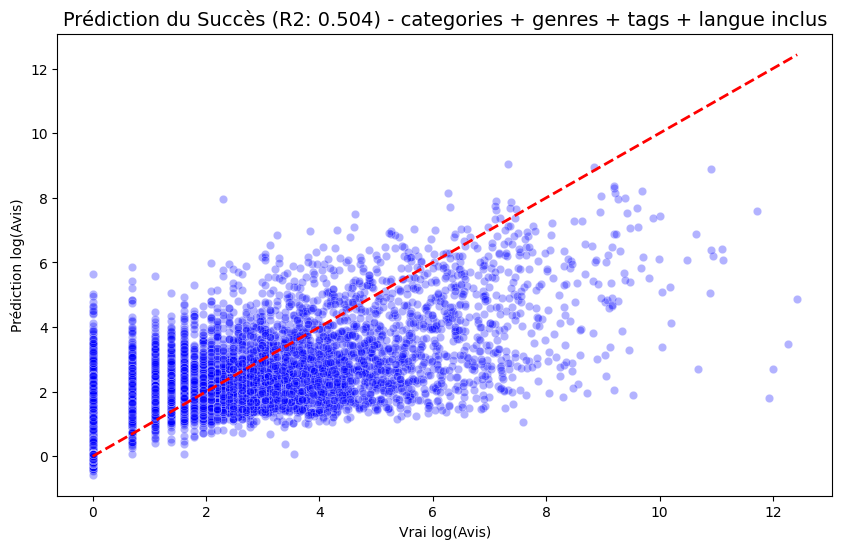

Exemples de prédictions :
                                                   Titre  Vrai_Avis  \
14492                                      Troubles Land        9.0   
2276                                     Alpacapaca Dash       63.0   
20370                                       Number Tower        0.0   
44705                                          Wild Fire        0.0   
26492                                        Deathstreak       10.0   
26341                                              JAMMO        0.0   
14832                      <Kobako> Training Arc | 岩斬り伝説        0.0   
8781                                     Build & Survive        1.0   
41435  Baobabs Mausoleum Grindhouse Edition - Country...        7.0   
5536                                    Speed and Scream        5.0   

       Prediction  
14492    7.298524  
2276     3.791642  
20370    7.463829  
44705    2.034103  
26492    4.122019  
26341    0.060633  
14832    0.060633  
8781     3.813420  
41435   71.9

In [28]:
cols_text = ["langues_partiel","langues_complet"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + langue inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

test tags

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

# 2. Multi-Hot Encoding
mlb = MultiLabelBinarizer(sparse_output=True)

# Transformation
tags_encoded = mlb.fit_transform(df['tags_utilisateurs'])

print(f"Nombre de tags uniques trouvés : {len(mlb.classes_)}")

tags_df = pd.DataFrame(tags_encoded.toarray(), columns=mlb.classes_, index=df.index)
pca_full = PCA()
pca_full.fit(tags_encoded)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.searchsorted(cumulative_variance, 0.95) + 1
n_components_90 = np.searchsorted(cumulative_variance, 0.90) + 1

print("Dimensions nécessaires pour 95% de variance :", n_components_95)
print("Dimensions nécessaires pour 90% de variance :", n_components_90)

pca = PCA(n_components=n_components_90)
tags_reduced = pca.fit_transform(tags_encoded)
df_pca = pd.DataFrame(
    tags_reduced,
    index=df.index,
    columns=[f'PC{i+1}' for i in range(tags_reduced.shape[1])]
)
df_pca

Nombre de tags uniques trouvés : 446
Dimensions nécessaires pour 95% de variance : 237
Dimensions nécessaires pour 90% de variance : 177


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC168,PC169,PC170,PC171,PC172,PC173,PC174,PC175,PC176,PC177
0,-0.312642,0.114451,-0.706298,-0.738606,-0.462244,0.148709,0.467612,0.465301,-0.287754,0.023539,...,-0.003723,-0.001079,0.004638,-0.007316,0.002899,-0.014926,-0.020970,0.001702,0.012270,-0.003435
1,0.773207,-0.845417,0.623685,-0.217569,-0.542979,0.419410,0.032185,-0.299094,0.146031,0.048646,...,0.057119,-0.139246,0.153431,0.044761,0.095199,-0.032237,0.057764,-0.187894,0.401185,0.139595
2,0.047936,-0.870139,-0.174175,0.000620,0.009022,0.871102,0.554064,0.187085,0.428441,0.369665,...,0.006191,0.047878,-0.039241,0.020057,0.045805,-0.012420,-0.028155,0.045699,0.004630,-0.021000
3,0.391873,0.850537,0.965200,0.000439,-0.289241,-0.465231,0.552857,0.226163,-0.691849,-0.088790,...,-0.043721,-0.014556,0.022398,0.010324,-0.041592,0.040501,0.078365,-0.056658,-0.044788,-0.004705
4,0.343287,-0.721291,1.042840,-0.099273,-0.155626,-0.632363,-0.088334,0.511585,0.558062,0.705532,...,0.090187,0.012166,0.129116,0.013006,-0.025987,0.032534,-0.084708,-0.090974,0.003383,-0.020110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46038,0.198725,-0.126408,-0.837474,-0.460958,0.286897,0.355951,1.028908,-0.014805,-0.076330,-0.627802,...,0.026651,-0.073246,-0.139939,0.011138,-0.009807,-0.022623,-0.051505,0.114565,0.055149,-0.062690
46039,0.804995,-0.771338,0.957855,0.027342,-0.253551,-0.438789,-0.217969,1.053177,0.084523,0.172992,...,0.036325,-0.016351,0.050315,0.034914,-0.005657,0.048354,0.148403,-0.040254,-0.043974,0.027277
46040,-1.155962,-0.770095,0.785932,0.257591,-0.104579,0.494793,-0.278402,-0.242704,-0.359517,-0.057360,...,-0.011087,-0.229580,0.281900,0.158323,0.091747,-0.000935,0.200327,-0.221833,0.321251,0.042648
46041,0.219311,0.327658,0.711219,-1.216891,-0.172052,0.155961,0.146552,0.279039,-0.001753,-0.017578,...,0.024900,0.004858,-0.018007,0.027011,0.007084,0.050735,0.028567,0.008153,-0.001566,0.024796


In [30]:
X = df[["support_manette","prix","nombre_succes",]].copy()
X = pd.concat([X,df_pca],axis=1)
numeric_cols = ["prix", "nombre_succes"]
Y = np.log1p(df['review'])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [31]:
lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0], cv=5, random_state=42)
lasso.fit(X_train, y_train)

y_pred_lr = lasso.predict(X_test)
y_pred = np.expm1(y_pred_lr)
print("Lasso R2:", r2_score(y_test, y_pred_lr))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"Meilleur alpha trouvé : {lasso.alpha_}")
print("Max réel (Log):", np.log1p(y_test).max())
print("Max prédiction (Log):", y_pred_lr.max())
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lasso.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Lasso R2: -0.004046232929233895
Lasso RMSE: 4764.422906033319
Meilleur alpha trouvé : 0.0001
Max réel (Log): 12.428319795196447
Max prédiction (Log): 8.287090463041359
    Feature      Coef
18     PC16  1.508024
59     PC57  1.061870
12     PC10 -0.763036
61     PC59  0.687117
126   PC124  0.680804
28     PC26  0.679807
11      PC9  0.674777
76     PC74  0.663285
114   PC112  0.635792
149   PC147 -0.630375


In [32]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)
y_pred_rf = rf.predict(X_test)
y_pred = np.expm1(y_pred_rf)
print("Random Forest R2:", r2_score(y_test_log, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2: 0.5504379964493419
Random Forest RMSE: 4770.631087134625


In [33]:
mlp = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=2000, random_state=42,activation='relu',solver='adam',early_stopping=True,verbose=True)
mlp.fit(X_train, y_train_log)
y_pred_mlp = mlp.predict(X_test)
y_pred = np.expm1(y_pred_mlp)
print("MLP R2:", r2_score(y_test_log, y_pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Iteration 1, loss = 1.87203464
Validation score: 0.289739
Iteration 2, loss = 1.46192186
Validation score: 0.342485
Iteration 3, loss = 1.26852145
Validation score: 0.411130
Iteration 4, loss = 1.11099669
Validation score: 0.447462
Iteration 5, loss = 1.02082498
Validation score: 0.447330
Iteration 6, loss = 0.96188690
Validation score: 0.461406
Iteration 7, loss = 0.90409015
Validation score: 0.463490
Iteration 8, loss = 0.84857211
Validation score: 0.465873
Iteration 9, loss = 0.80667793
Validation score: 0.460507
Iteration 10, loss = 0.76817095
Validation score: 0.457076
Iteration 11, loss = 0.73138232
Validation score: 0.444977
Iteration 12, loss = 0.69479603
Validation score: 0.449319
Iteration 13, loss = 0.66913557
Validation score: 0.439952
Iteration 14, loss = 0.63690107
Validation score: 0.447091
Iteration 15, loss = 0.60738996
Validation score: 0.442025
Iteration 16, loss = 0.58150770
Validation score: 0.437118
Iteration 17, loss = 0.55925738
Validation score: 0.430730
Iterat

In [34]:
X

,support_manette,prix,nombre_succes,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC168,PC169,PC170,PC171,PC172,PC173,PC174,PC175,PC176,PC177
0,False,99,0,-0.312642,0.114451,-0.706298,-0.738606,-0.462244,0.148709,0.467612,...,-0.003723,-0.001079,0.004638,-0.007316,0.002899,-0.014926,-0.020970,0.001702,0.012270,-0.003435
1,False,0,0,0.773207,-0.845417,0.623685,-0.217569,-0.542979,0.419410,0.032185,...,0.057119,-0.139246,0.153431,0.044761,0.095199,-0.032237,0.057764,-0.187894,0.401185,0.139595
2,False,1679,43,0.047936,-0.870139,-0.174175,0.000620,0.009022,0.871102,0.554064,...,0.006191,0.047878,-0.039241,0.020057,0.045805,-0.012420,-0.028155,0.045699,0.004630,-0.021000
3,False,0,0,0.391873,0.850537,0.965200,0.000439,-0.289241,-0.465231,0.552857,...,-0.043721,-0.014556,0.022398,0.010324,-0.041592,0.040501,0.078365,-0.056658,-0.044788,-0.004705
4,False,79,0,0.343287,-0.721291,1.042840,-0.099273,-0.155626,-0.632363,-0.088334,...,0.090187,0.012166,0.129116,0.013006,-0.025987,0.032534,-0.084708,-0.090974,0.003383,-0.020110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46038,False,1249,0,0.198725,-0.126408,-0.837474,-0.460958,0.286897,0.355951,1.028908,...,0.026651,-0.073246,-0.139939,0.011138,-0.009807,-0.022623,-0.051505,0.114565,0.055149,-0.062690
46039,False,199,0,0.804995,-0.771338,0.957855,0.027342,-0.253551,-0.438789,-0.217969,...,0.036325,-0.016351,0.050315,0.034914,-0.005657,0.048354,0.148403,-0.040254,-0.043974,0.027277
46040,False,0,0,-1.155962,-0.770095,0.785932,0.257591,-0.104579,0.494793,-0.278402,...,-0.011087,-0.229580,0.281900,0.158323,0.091747,-0.000935,0.200327,-0.221833,0.321251,0.042648
46041,False,999,59,0.219311,0.327658,0.711219,-1.216891,-0.172052,0.155961,0.146552,...,0.024900,0.004858,-0.018007,0.027011,0.007084,0.050735,0.028567,0.008153,-0.001566,0.024796


0:	learn: 2.0401385	test: 4770.8252601	best: 4770.8252601 (0)	total: 83ms	remaining: 2m 45s
200:	learn: 1.3175582	test: 4770.5938804	best: 4770.5938177 (197)	total: 15s	remaining: 2m 13s
400:	learn: 1.2529779	test: 4770.5714128	best: 4770.5714128 (400)	total: 28.9s	remaining: 1m 55s
600:	learn: 1.2111710	test: 4770.5658148	best: 4770.5658148 (600)	total: 43s	remaining: 1m 40s
800:	learn: 1.1773003	test: 4770.5632490	best: 4770.5625432 (760)	total: 57.1s	remaining: 1m 25s
1000:	learn: 1.1483512	test: 4770.5585043	best: 4770.5584435 (996)	total: 1m 11s	remaining: 1m 11s
1200:	learn: 1.1228099	test: 4770.5569928	best: 4770.5569755 (1199)	total: 1m 25s	remaining: 57.2s
1400:	learn: 1.1002163	test: 4770.5543572	best: 4770.5543346 (1389)	total: 1m 40s	remaining: 42.9s
1600:	learn: 1.0789040	test: 4770.5531687	best: 4770.5531237 (1541)	total: 1m 54s	remaining: 28.6s
1800:	learn: 1.0591817	test: 4770.5517460	best: 4770.5517189 (1797)	total: 2m 9s	remaining: 14.3s
1999:	learn: 1.0404517	test: 4

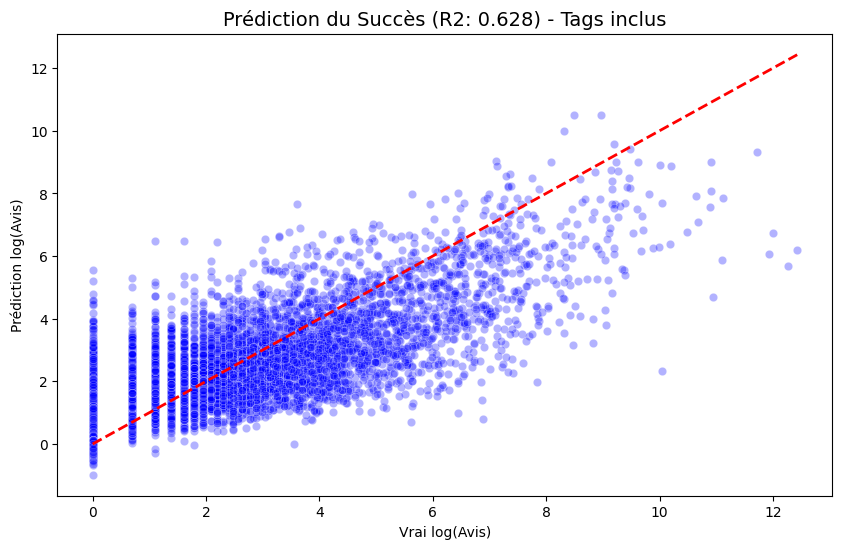

In [35]:
cols_text = ["tags_utilisateurs"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 6. Entraînement CatBoost (Le modèle final)
cb = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=7,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=200,
    early_stopping_rounds=100,
    task_type="CPU"
)

cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 7. Affichage des résultats pour ton rapport
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))

# 8. Graphique "Preuve de réussite"
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - Tags inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

Test catboost text

Entraînement sur le texte : ['description_detaillee']...
Learning rate set to 0.089701
0:	learn: 2.0145828	test: 4770.8227993	best: 4770.8227993 (0)	total: 320ms	remaining: 5m 20s
100:	learn: 1.4402716	test: 4770.6662902	best: 4770.6661494 (95)	total: 25.1s	remaining: 3m 42s
200:	learn: 1.3605308	test: 4770.6530483	best: 4770.6529121 (199)	total: 47.2s	remaining: 3m 7s
300:	learn: 1.2995755	test: 4770.6452755	best: 4770.6451998 (296)	total: 1m 8s	remaining: 2m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 4770.644175
bestIteration = 308

Shrink model to first 309 iterations.

🏆 SCORE FINAL (R2 Log) : 0.5128
RMSE: 4740.9338773674735

 SCORE TRAIN (R2 Log) : 0.6152
Erreur Médiane : 4.323054445889412

Top Facteurs de Succès :
              Feature Id  Importances
0  description_detaillee    43.963508
1                   prix    37.591449
2          nombre_succes    18.445044
3        support_manette     0.000000


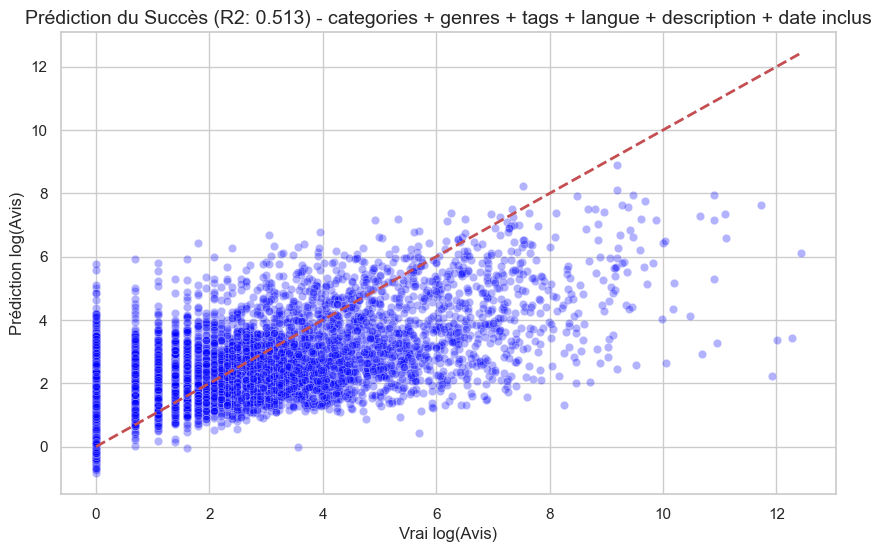

Exemples de prédictions :
                               Titre  Vrai_Avis  Prediction
25033               Magic University       10.0    5.623662
20090                     Cumbersome        0.0    1.141048
20633                     AdvertCity       40.0   80.703486
22021                   Overflo Game        0.0   -0.074078
1295   Slime-san: Blackbird's Kraken        3.0    9.241650
16765      Pulsar, The VR Experience        2.0   10.165731
39189    Circlebrix - Falling Bricks        0.0    1.909524
35243                    Shiba Sweet        0.0    0.060959
18476                     Ravenfield    43669.0   17.627398
35729                        McPixel     1357.0    5.206902
              Feature Id  Importances
0  description_detaillee    43.963508
1                   prix    37.591449
2          nombre_succes    18.445044
3        support_manette     0.000000


In [66]:
cols_text = ["description_detaillee"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

features = cols_cat+cols_text+numeric_cols
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    depth=8,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    task_type="CPU",
    early_stopping_rounds=30
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + langue + description + date inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Entraînement sur le texte : ['description_courte']...
0:	learn: 2.0464904	test: 4770.8278621	best: 4770.8278621 (0)	total: 1.16s	remaining: 9m 37s
100:	learn: 1.5000244	test: 4770.6888542	best: 4770.6888542 (100)	total: 1m 30s	remaining: 5m 58s
200:	learn: 1.4700683	test: 4770.6820874	best: 4770.6820874 (200)	total: 2m 50s	remaining: 4m 13s
300:	learn: 1.4268764	test: 4770.6764431	best: 4770.6764431 (300)	total: 4m 19s	remaining: 2m 51s
400:	learn: 1.3900120	test: 4770.6748987	best: 4770.6748987 (400)	total: 5m 46s	remaining: 1m 25s
499:	learn: 1.3588412	test: 4770.6738507	best: 4770.6737650 (494)	total: 7m 6s	remaining: 0us

bestTest = 4770.673765
bestIteration = 494

Shrink model to first 495 iterations.

🏆 SCORE FINAL (R2 Log) : 0.4784
RMSE: 4750.595917000945

Top Facteurs de Succès :
           Feature Id  Importances
0                prix    43.106916
1  description_courte    33.337592
2       nombre_succes    23.555492
3     support_manette     0.000000


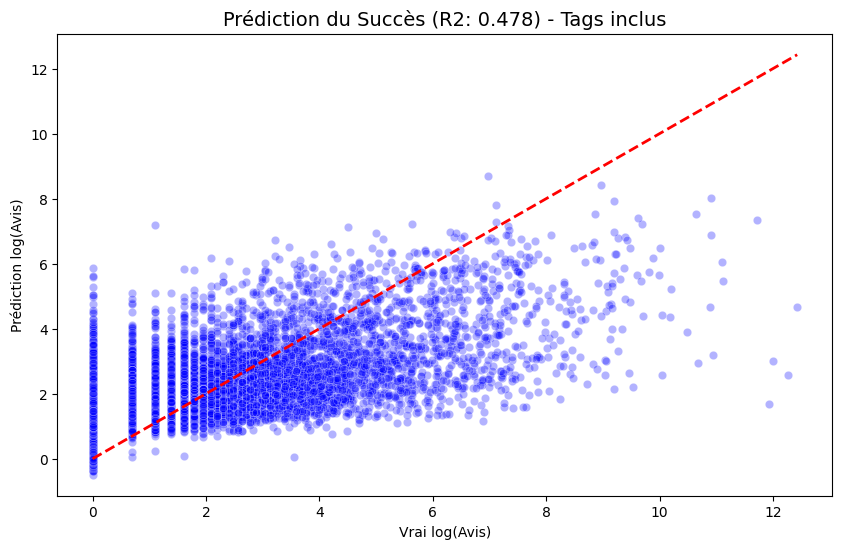

Exemples de prédictions :
                                              Titre  Vrai_Avis  Prediction
31909  Slot Factory Create and Play - Magic Brewery        1.0    3.973564
1771                                       APT. 407       13.0    3.879284
43068                                  Combo Jumper        2.0    3.570880
9288                                           天鶴之戀        0.0    2.637326
13294                                    How We Die        1.0  118.433185
2789                                      KILLNETIC        0.0    0.107427
28388                                  Zombie Towns        2.0    1.494115
3108                 Flyland Wars: 1 Mountain Climb        1.0    2.178343
23898                   Extreme Car Drift Simulator        4.0    1.801076
3899                                      Pipelinks        1.0    1.440343
           Feature Id  Importances
0                prix    43.106916
1  description_courte    33.337592
2       nombre_succes    23.555492
3     sup

In [39]:
cols_text = ["description_courte"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"


X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - Tags inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

# Exemple de lecture pour quelques jeux
results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction':y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

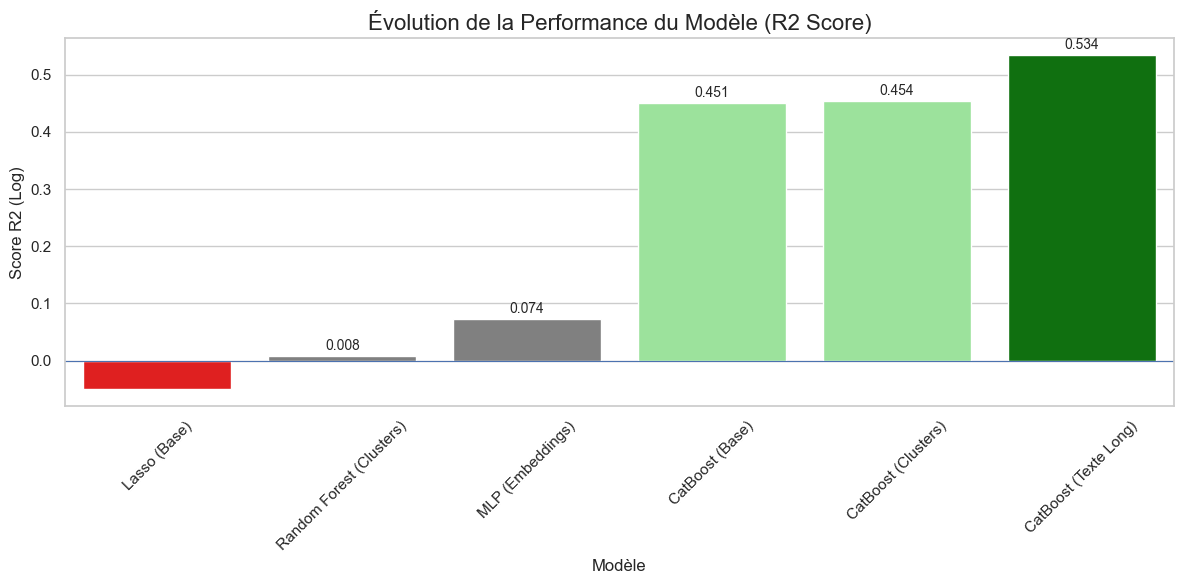

In [40]:
# Tes résultats (approximatifs basés sur nos échanges)
results = pd.DataFrame({
    'Modèle': ['Lasso (Base)', 'Random Forest (Clusters)', 'MLP (Embeddings)','CatBoost (Base)','CatBoost (Clusters)', 'CatBoost (Texte Long)'],
    'R2 Score (Log Space)': [-0.05,0.008, 0.0736,0.451,0.454, 0.534],
    'Type': ['Echec', 'Baseline','Baseline','Baseline', 'Echec','Meilleur']
})

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

colors = [
    'red' if x < 0
    else 'grey' if x < 0.2
    else 'lightgreen' if x < 0.52
    else 'green'
    for x in results['R2 Score (Log Space)']
]

sns.barplot(
    data=results,
    x='Modèle',
    y='R2 Score (Log Space)',
    hue='Modèle',
    palette=colors,
    legend=False
)

plt.title('Évolution de la Performance du Modèle (R2 Score)', fontsize=16)
plt.ylabel('Score R2 (Log)', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(0, linewidth=0.8)

for i, v in enumerate(results['R2 Score (Log Space)']):
    if v > 0:
        plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()

TEST VISON embedding

Test genre catégorie catboost

Entraînement sur le texte : ['genres']...
0:	learn: 2.0431051	test: 4770.8270819	best: 4770.8270819 (0)	total: 177ms	remaining: 1m 28s
100:	learn: 1.4268430	test: 4770.6634076	best: 4770.6634076 (100)	total: 7.06s	remaining: 27.9s
200:	learn: 1.3978330	test: 4770.6518248	best: 4770.6518248 (200)	total: 14.5s	remaining: 21.5s
300:	learn: 1.3661589	test: 4770.6488211	best: 4770.6486046 (287)	total: 20.3s	remaining: 13.4s
400:	learn: 1.3401630	test: 4770.6450635	best: 4770.6449744 (395)	total: 26.1s	remaining: 6.43s
499:	learn: 1.3227171	test: 4770.6441770	best: 4770.6441770 (499)	total: 32.2s	remaining: 0us

bestTest = 4770.644177
bestIteration = 499


🏆 SCORE FINAL (R2 Log) : 0.5344
RMSE: 4736.837277818044

Top Facteurs de Succès :
        Feature Id  Importances
0           genres    41.943657
1             prix    36.227771
2    nombre_succes    21.828572
3  support_manette     0.000000


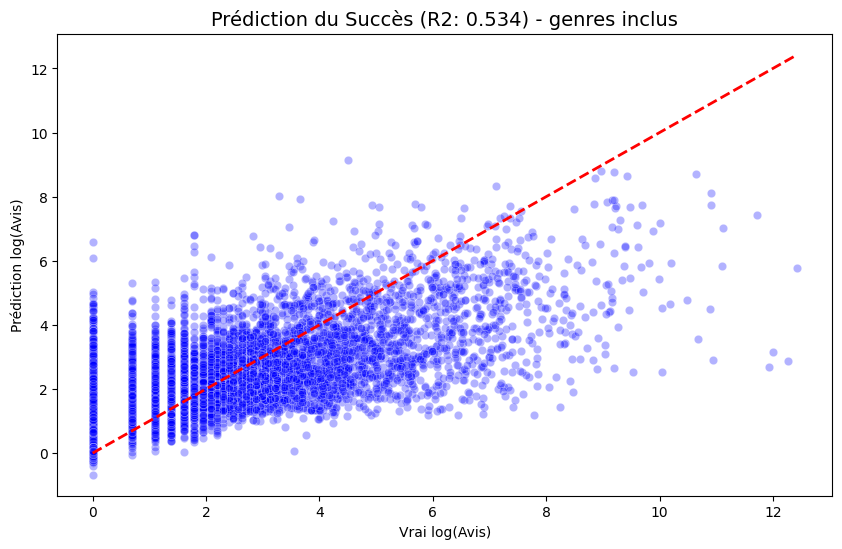

Exemples de prédictions :
                                    Titre  Vrai_Avis  Prediction
385                          FILMECHANISM       10.0   34.122773
34410  7 Grand Steps: What Ancients Begat      266.0   40.805565
2848                             NAGAISAN       27.0   15.178788
16841             The Hero Of Pixel Spire        0.0   -0.124832
29695           STUDIO SCREAM - VERSE ONE        3.0    4.413564
41849                    Aery - Stone Age        7.0   20.810661
21910                         Jump Higher        0.0    8.547120
6156                        Himeko Sutori      164.0   48.557014
37142                Motel Life Simulator        0.0    0.027721
17979                        The Occluder        1.0    1.782210
        Feature Id  Importances
0           genres    41.943657
1             prix    36.227771
2    nombre_succes    21.828572
3  support_manette     0.000000


In [12]:
cols_text = ["genres"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - genres inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

# Exemple de lecture pour quelques jeux
results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction':y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Entraînement sur le texte : ['categories']...
0:	learn: 2.0343456	test: 4770.8254815	best: 4770.8254815 (0)	total: 189ms	remaining: 1m 34s
100:	learn: 1.2862010	test: 4770.5940515	best: 4770.5940515 (100)	total: 21.2s	remaining: 1m 23s
200:	learn: 1.2502156	test: 4770.5785585	best: 4770.5785585 (200)	total: 47.7s	remaining: 1m 10s
300:	learn: 1.2141014	test: 4770.5729128	best: 4770.5729128 (300)	total: 1m 9s	remaining: 46.2s
400:	learn: 1.1904166	test: 4770.5704074	best: 4770.5704074 (400)	total: 1m 34s	remaining: 23.3s
499:	learn: 1.1734970	test: 4770.5686375	best: 4770.5686375 (499)	total: 1m 55s	remaining: 0us

bestTest = 4770.568638
bestIteration = 499


🏆 SCORE FINAL (R2 Log) : 0.6318
RMSE: 4692.755428223249

Top Facteurs de Succès :
        Feature Id  Importances
0       categories    57.248711
1             prix    32.940410
2    nombre_succes     9.810879
3  support_manette     0.000000


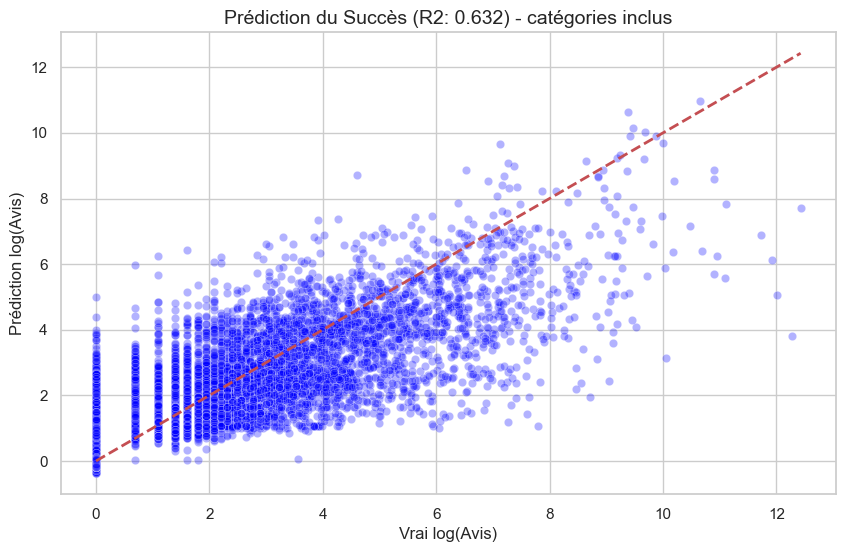

Exemples de prédictions :
                                                   Titre  Vrai_Avis  \
18941                                       Birdsketball       39.0   
39771               The Palaces of The Mind: Chapter One        0.0   
40687  Questerium: Sinister Trinity HD Collector's Ed...       98.0   
21130                                   Oscar's Paradise        0.0   
4569       Darkness Within 1: In Pursuit of Loath Nolder      262.0   
4337                     The Dreamlands: Aisling's Quest        9.0   
37933                                 Arena Drift Master        8.0   
37851                        Shooting Squirrel Simulator        4.0   
41825                                         SpellFront       16.0   
5053                            101 Cats Hidden in Tokyo       25.0   

       Prediction  
18941   51.794437  
39771    1.161530  
40687   67.825255  
21130    0.023440  
4569    14.424576  
4337    15.591056  
37933    6.501420  
37851    2.798567  
41825   13.2

In [42]:
cols_text = ["categories"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,          # Raisonnable pour commencer
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"           # Mets "GPU" si tu peux, ça ira 10x plus vite
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - catégories inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

# Exemple de lecture pour quelques jeux
results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Test genre + categorie

Entraînement sur le texte : ['categories', 'genres']...
0:	learn: 2.0344530	test: 4770.8238261	best: 4770.8238261 (0)	total: 356ms	remaining: 2m 57s
100:	learn: 1.2615163	test: 4770.5929002	best: 4770.5929002 (100)	total: 30.9s	remaining: 2m 1s
200:	learn: 1.2182683	test: 4770.5746481	best: 4770.5746481 (200)	total: 1m 3s	remaining: 1m 34s
300:	learn: 1.1776516	test: 4770.5674701	best: 4770.5674701 (300)	total: 1m 29s	remaining: 59.3s
400:	learn: 1.1477596	test: 4770.5643868	best: 4770.5642237 (395)	total: 1m 55s	remaining: 28.5s
499:	learn: 1.1248538	test: 4770.5618343	best: 4770.5618292 (497)	total: 2m 21s	remaining: 0us

bestTest = 4770.561829
bestIteration = 497

Shrink model to first 498 iterations.

🏆 SCORE FINAL (R2 Log) : 0.6491
RMSE: 4667.967996498969

Top Facteurs de Succès :
        Feature Id  Importances
0       categories    46.503065
1             prix    29.784937
2           genres    13.520258
3    nombre_succes    10.191740
4  support_manette     0.000000


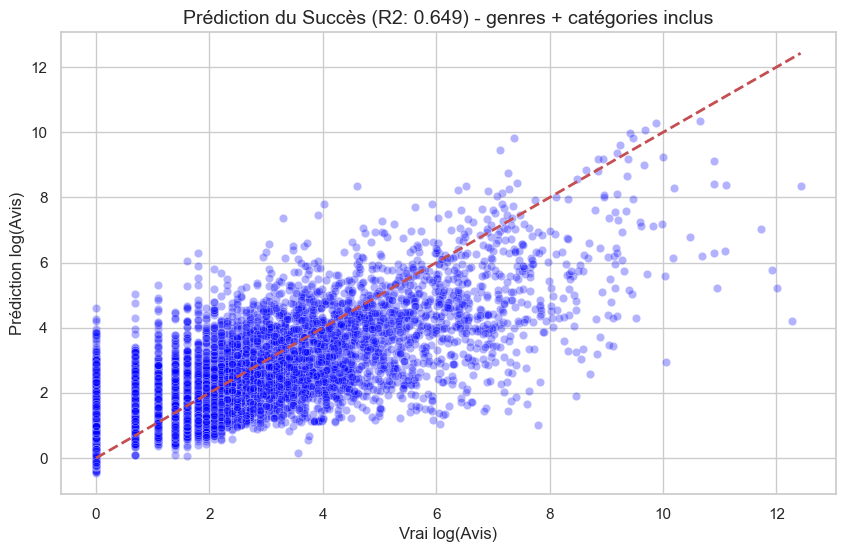

Exemples de prédictions :
                                          Titre  Vrai_Avis  Prediction
44349                                    Qurtys        1.0    2.553104
17724                           Shining In Mind        0.0    2.202774
17183          The Hunt for the Lost Treasure 2        1.0    5.506824
1985   Touhou Iyuushou ~ What the Bullet Hell?!        0.0   -0.203976
30148                        Reinforced Machine        0.0    0.028967
35661                       Multiplayer Mummies        1.0    1.877193
6267                              Happy Cookies        2.0    4.880024
36867                                Trapsetter        0.0    0.163782
29911                   Food Delivery Simulator       53.0   14.119368
38686                          Checkers & Pawns        2.0    1.220748
        Feature Id  Importances
0       categories    46.503065
1             prix    29.784937
2           genres    13.520258
3    nombre_succes    10.191740
4  support_manette     0.000000


In [43]:
cols_text = ["categories","genres"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,          # Raisonnable pour commencer
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"           # Mets "GPU" si tu peux, ça ira 10x plus vite
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - genres + catégories inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

# Exemple de lecture pour quelques jeux
results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Test genre + categorie + tags

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs']...
0:	learn: 2.0349441	test: 4770.8250640	best: 4770.8250640 (0)	total: 853ms	remaining: 14m 11s
100:	learn: 1.1820010	test: 4770.5670805	best: 4770.5670805 (100)	total: 1m 22s	remaining: 12m 16s
200:	learn: 1.1167754	test: 4770.5404250	best: 4770.5404250 (200)	total: 2m 40s	remaining: 10m 37s
300:	learn: 1.0590071	test: 4770.5301618	best: 4770.5301334 (298)	total: 4m	remaining: 9m 19s
400:	learn: 1.0168910	test: 4770.5231952	best: 4770.5231616 (399)	total: 5m 27s	remaining: 8m 9s
500:	learn: 0.9833676	test: 4770.5184923	best: 4770.5183349 (498)	total: 6m 58s	remaining: 6m 56s
600:	learn: 0.9564701	test: 4770.5142437	best: 4770.5142430 (589)	total: 8m 27s	remaining: 5m 37s
700:	learn: 0.9317176	test: 4770.5123694	best: 4770.5123694 (700)	total: 9m 49s	remaining: 4m 11s
800:	learn: 0.9086985	test: 4770.5105777	best: 4770.5104927 (797)	total: 11m 9s	remaining: 2m 46s
900:	learn: 0.8881652	test: 4770.5078122	best: 4

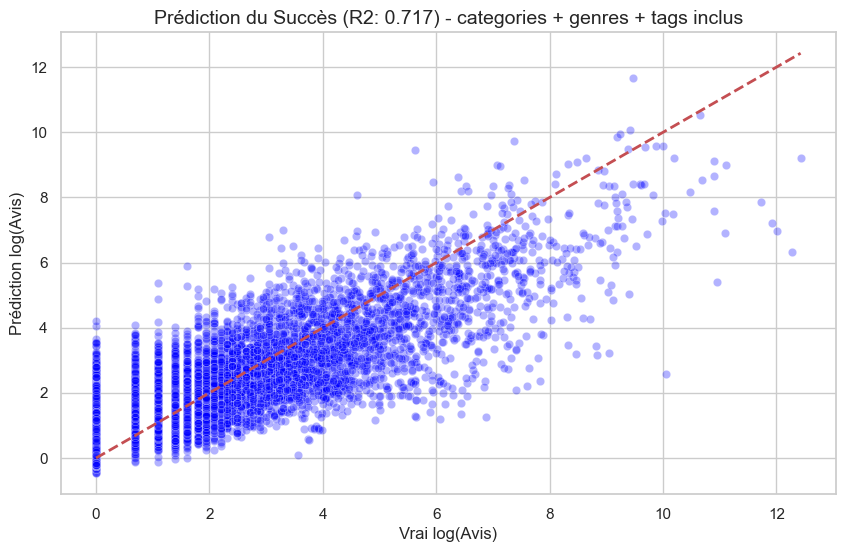

Exemples de prédictions :
                                 Titre  Vrai_Avis  Prediction
30404                    Red Pill Cola        1.0    1.706382
43205                Path of Sacrifice        5.0    2.509022
20816                 A Bonnie Odyssey        0.0    0.054848
7945                    Chrono Project        2.0    1.114755
36223                         Isolated        0.0    7.269801
25238                         VRetired        2.0   12.801901
7891                        Lost Souls        5.0   15.562067
27582  Void Crew - Original Soundtrack        0.0    7.754908
4614                      Bullet Blade        0.0   -0.199923
20235                      Aster Force        2.0    1.260837
          Feature Id  Importances
0  tags_utilisateurs    31.225663
1         categories    30.348839
2               prix    24.586660
3      nombre_succes     8.291371
4             genres     5.547467
5    support_manette     0.000000


In [44]:
cols_text = ["categories","genres","tags_utilisateurs"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"           # Mets "GPU" si tu peux, ça ira 10x plus vite
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'description_detaillee']...
0:	learn: 2.0339473	test: 4770.8255546	best: 4770.8255546 (0)	total: 1.83s	remaining: 15m 14s
100:	learn: 1.1850701	test: 4770.5668506	best: 4770.5668506 (100)	total: 3m 2s	remaining: 12m 2s
200:	learn: 1.1181739	test: 4770.5432722	best: 4770.5432722 (200)	total: 6m 11s	remaining: 9m 12s
300:	learn: 1.0511319	test: 4770.5326289	best: 4770.5326289 (300)	total: 9m 31s	remaining: 6m 17s
400:	learn: 0.9996648	test: 4770.5269476	best: 4770.5268099 (398)	total: 12m 41s	remaining: 3m 8s
499:	learn: 0.9593563	test: 4770.5220843	best: 4770.5220843 (499)	total: 15m 22s	remaining: 0us

bestTest = 4770.522084
bestIteration = 499


🏆 SCORE FINAL (R2 Log) : 0.7045
RMSE: 4630.366222390234

 SCORE TRAIN (R2 Log) : 0.7888
Erreur Médiane : 2.8644715430759486

Top Facteurs de Succès :
              Feature Id  Importances
0             categories    28.611103
1                   prix    26.090315
2      

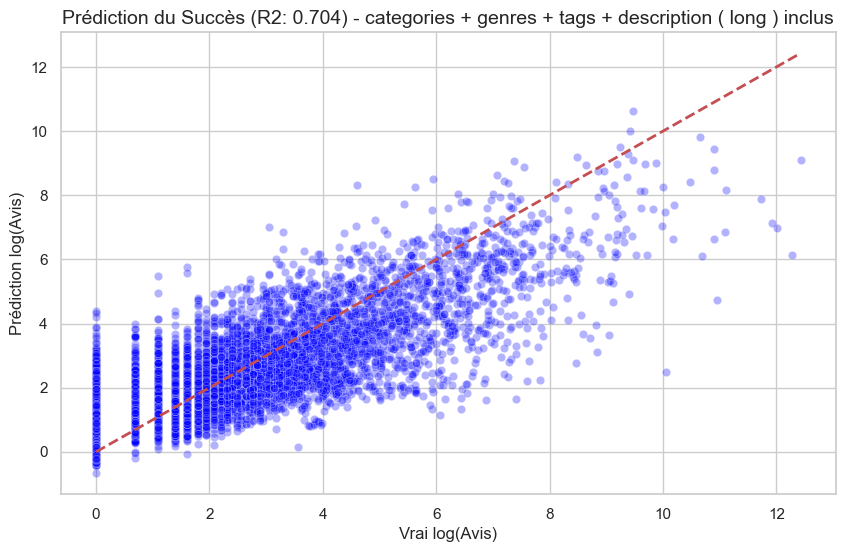

Exemples de prédictions :
                            Titre  Vrai_Avis  Prediction
44815                  Mana Logic        0.0    1.821483
31686                Alien Attack       68.0   28.516385
377      東方苦粗芸物語 Touhou KSG Story        2.0    3.434084
23498                        2184        0.0    0.297695
24334           The Ghost Soprano        3.0    4.328533
13966                    Mutiny!!      126.0   65.405061
1003   逃出图书馆(Escape from Library)        1.0    3.961792
12859                    BomboCat        3.0    2.560706
20218                     DeDrive        4.0    1.870575
6756                    The Hotel       25.0    6.233799
              Feature Id  Importances
0             categories    28.611103
1                   prix    26.090315
2      tags_utilisateurs    22.720994
3  description_detaillee    10.902108
4          nombre_succes     7.730426
5                 genres     3.945054
6        support_manette     0.000000


In [45]:
cols_text = ["categories","genres","tags_utilisateurs","description_detaillee"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"           # Mets "GPU" si tu peux, ça ira 10x plus vite
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + description ( long ) inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'description_detaillee']...
0:	learn: 2.0339473	test: 4770.8255546	best: 4770.8255546 (0)	total: 1.78s	remaining: 29m 44s
100:	learn: 1.1850701	test: 4770.5668506	best: 4770.5668506 (100)	total: 2m 42s	remaining: 24m 8s
200:	learn: 1.1181739	test: 4770.5432722	best: 4770.5432722 (200)	total: 5m 18s	remaining: 21m 7s
300:	learn: 1.0511319	test: 4770.5326289	best: 4770.5326289 (300)	total: 8m 2s	remaining: 18m 40s
400:	learn: 0.9996648	test: 4770.5269476	best: 4770.5268099 (398)	total: 10m 43s	remaining: 16m 1s
500:	learn: 0.9589130	test: 4770.5220358	best: 4770.5220358 (500)	total: 13m 25s	remaining: 13m 22s
600:	learn: 0.9228862	test: 4770.5198040	best: 4770.5198040 (600)	total: 16m 2s	remaining: 10m 38s
700:	learn: 0.8918553	test: 4770.5175563	best: 4770.5175558 (699)	total: 18m 51s	remaining: 8m 2s
800:	learn: 0.8632610	test: 4770.5167094	best: 4770.5165724 (798)	total: 21m 35s	remaining: 5m 21s
900:	learn: 0.8

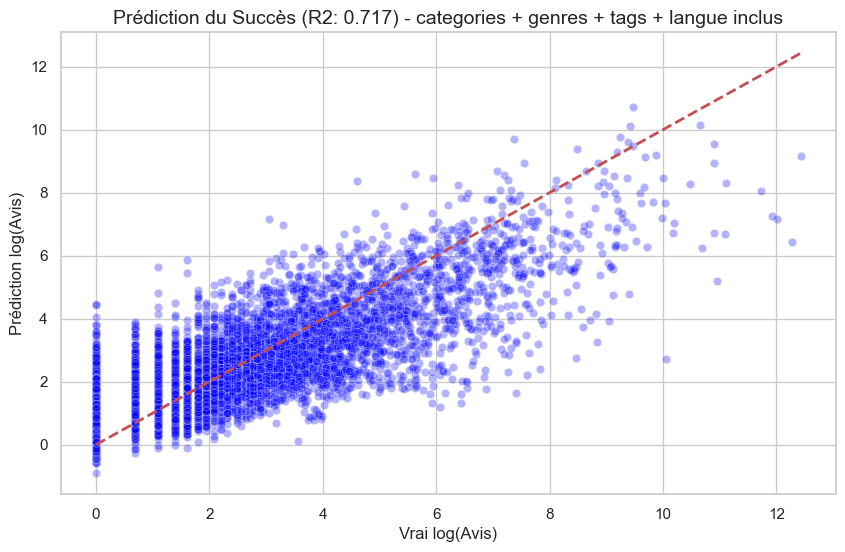

Exemples de prédictions :
                      Titre  Vrai_Avis  Prediction
2624   Bakery Shop Match Up        0.0    2.077021
25691   Coconut Simulator 2        0.0    0.019220
6682            Iselin Saga        3.0    1.447678
6196         Venice Bridges        2.0    4.205688
17456                Clan N        9.0   44.239878
14673       Stellar Shapers        0.0    3.112765
20483               Talents        7.0   25.880975
29744            Fire Thief        3.0    1.522580
21982              Ghostory       22.0   91.956149
13862          ArtPuzzle VR        0.0    5.646799
              Feature Id  Importances
0             categories    26.230022
1                   prix    23.605711
2      tags_utilisateurs    22.805735
3  description_detaillee    16.070309
4          nombre_succes     7.266760
5                 genres     4.021463
6        support_manette     0.000000


In [46]:
cols_text = ["categories","genres","tags_utilisateurs","description_detaillee"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + langue inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Test genre catégorie tags langue

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'langues_partiel', 'langues_complet']...
Learning rate set to 0.089701
0:	learn: 1.9886894	test: 4770.8171494	best: 4770.8171494 (0)	total: 953ms	remaining: 15m 52s
100:	learn: 1.1160873	test: 4770.5423499	best: 4770.5423499 (100)	total: 1m 38s	remaining: 14m 35s
200:	learn: 1.0151353	test: 4770.5264586	best: 4770.5264586 (200)	total: 3m 17s	remaining: 13m 7s
300:	learn: 0.9538219	test: 4770.5204010	best: 4770.5204010 (300)	total: 5m 13s	remaining: 12m 8s
400:	learn: 0.9077042	test: 4770.5150936	best: 4770.5148969 (390)	total: 7m	remaining: 10m 27s
500:	learn: 0.8690678	test: 4770.5127514	best: 4770.5127514 (500)	total: 8m 39s	remaining: 8m 37s
600:	learn: 0.8348285	test: 4770.5102864	best: 4770.5099440 (590)	total: 10m 19s	remaining: 6m 51s
700:	learn: 0.8058213	test: 4770.5087083	best: 4770.5085154 (684)	total: 11m 58s	remaining: 5m 6s
800:	learn: 0.7779696	test: 4770.5065628	best: 4770.5065185 (796)	total: 13m

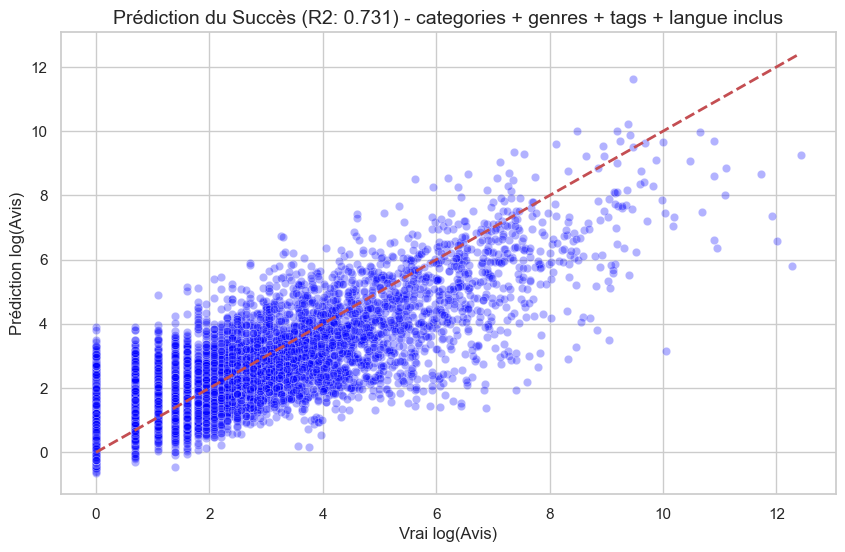

Exemples de prédictions :
                                Titre  Vrai_Avis  Prediction
29490                    War Platform        2.0   33.203006
12027  梦魇：无归 Nightmare without return        4.0    0.058100
36377                Legend of Kendor       19.0    6.518214
447                           Quarion       76.0    2.914977
8569                        Nano.wars        1.0    0.990602
21641                       Squeakers       31.0   15.064112
36882                          Growth      118.0   64.901139
22524             Dish Life: The Game        3.0    6.761567
25804                      BulletLive        0.0    4.540932
26858                    Seek & Snipe        0.0   -0.016622
          Feature Id  Importances
0  tags_utilisateurs    29.347660
1         categories    27.226031
2               prix    22.390789
3      nombre_succes     7.169959
4             genres     5.339637
5    langues_partiel     5.209232
6  N_langues_partiel     1.707874
7    langues_complet     1.3786

In [47]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet"]
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    task_type="CPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + langue inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'langues_partiel', 'langues_complet', 'description_detaillee']...
Learning rate set to 0.089701
0:	learn: 1.9907144	test: 4770.8160271	best: 4770.8160271 (0)	total: 1.75s	remaining: 29m 12s
100:	learn: 1.1205744	test: 4770.5495111	best: 4770.5495111 (100)	total: 2m 58s	remaining: 26m 24s
200:	learn: 1.0038109	test: 4770.5292564	best: 4770.5292525 (199)	total: 5m 53s	remaining: 23m 23s
300:	learn: 0.9309161	test: 4770.5241994	best: 4770.5241102 (271)	total: 8m 54s	remaining: 20m 41s
400:	learn: 0.8776520	test: 4770.5192547	best: 4770.5192058 (399)	total: 12m 7s	remaining: 18m 6s
500:	learn: 0.8308956	test: 4770.5156343	best: 4770.5154718 (497)	total: 15m 21s	remaining: 15m 17s
600:	learn: 0.7928395	test: 4770.5127115	best: 4770.5127115 (600)	total: 19m 1s	remaining: 12m 37s
700:	learn: 0.7560395	test: 4770.5123969	best: 4770.5123969 (700)	total: 22m 4s	remaining: 9m 24s
800:	learn: 0.7243565	test: 4770.5125519	bes

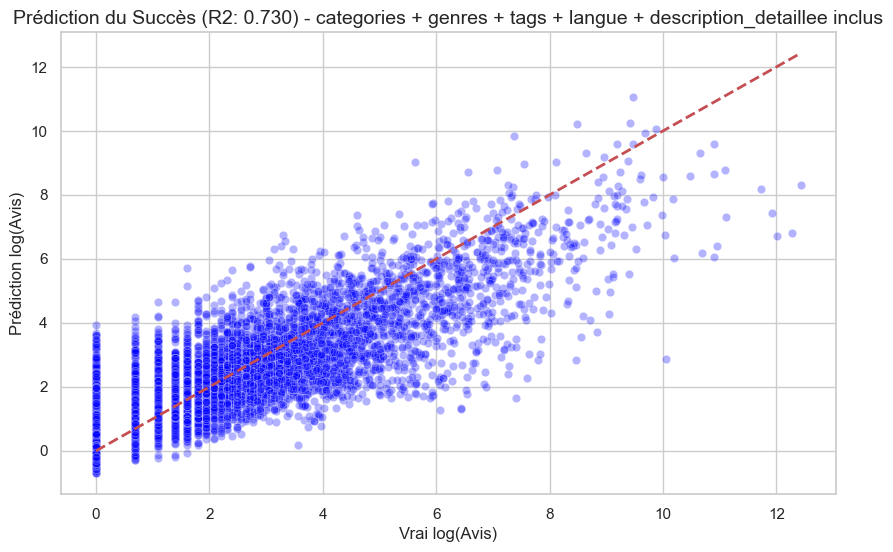

Exemples de prédictions :
                         Titre  Vrai_Avis  Prediction
43055           Shadow of Fear        0.0    1.418511
19688  Speed Dating for Ghosts      426.0  114.927463
588               TEXT: Russia        1.0    3.467900
25781        Theriothron Spire        0.0   -0.442808
9036         FORTUNE the FATED        3.0    7.854768
36442            Miner Clicker        0.0   -0.193876
35137                 Fast:Run        0.0    0.507324
39754           Extreme flight        0.0   -0.000522
12701    Operation: Black Mesa        0.0    0.597755
22975                 TOGETHER        0.0    0.158138
               Feature Id  Importances
0              categories    23.491389
1                    prix    21.061708
2       tags_utilisateurs    20.897758
3   description_detaillee    17.248789
4           nombre_succes     7.035832
5         langues_partiel     4.303505
6                  genres     3.952145
7         langues_complet     1.030208
8       N_langues_partiel    

In [48]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet","description_detaillee"]
cols_cat = ["mois","annee"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)
Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    depth=10,
    text_features=cols_text,
    verbose=100,
    task_type="CPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + langue + description_detaillee inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'langues_partiel', 'langues_complet', 'description_detaillee']...
Learning rate set to 0.089701
0:	learn: 1.9964527	test: 4770.8191351	best: 4770.8191351 (0)	total: 820ms	remaining: 13m 39s
100:	learn: 1.0855305	test: 4770.5357049	best: 4770.5357049 (100)	total: 1m 6s	remaining: 9m 51s
200:	learn: 0.9978731	test: 4770.5151350	best: 4770.5151350 (200)	total: 2m 6s	remaining: 8m 22s
300:	learn: 0.9440532	test: 4770.5089546	best: 4770.5089546 (300)	total: 3m 3s	remaining: 7m 6s
400:	learn: 0.9018387	test: 4770.5031237	best: 4770.5029629 (396)	total: 3m 59s	remaining: 5m 58s
500:	learn: 0.8674517	test: 4770.4991464	best: 4770.4986668 (493)	total: 4m 53s	remaining: 4m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 4770.498667
bestIteration = 493

Shrink model to first 494 iterations.

🏆 SCORE FINAL (R2 Log) : 0.7493
RMSE: 4726.788723140264

 SCORE TRAIN (R2 Log) : 0.8267
Erreur Médiane : 2.56483

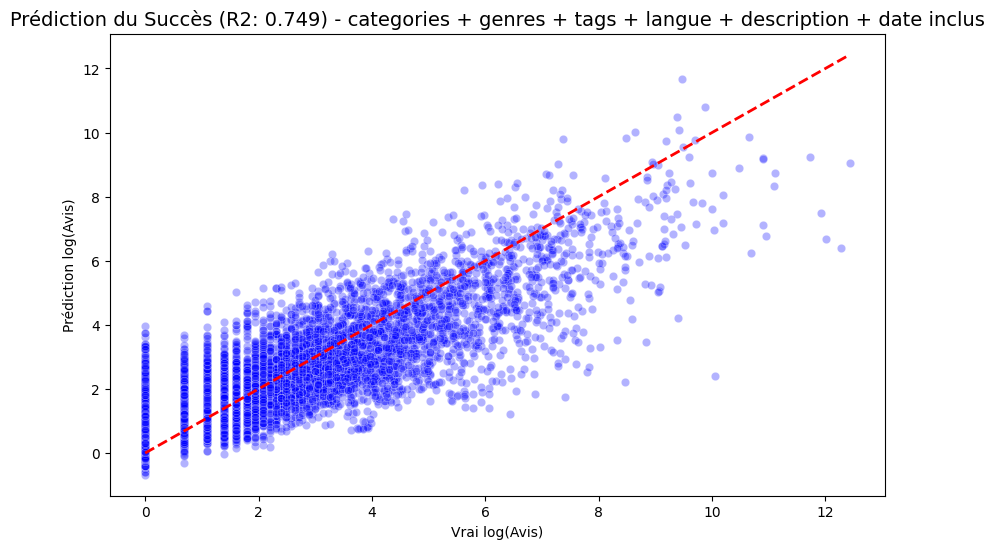

Exemples de prédictions :
                                Titre  Vrai_Avis   Prediction
31166                      GleanBound        0.0    -0.145306
24382                   Notes of Soul       44.0    21.148678
15507                     Alpine Lake        0.0     0.129171
32181         Cruise Control Mode On!        4.0     5.708736
36196            Guardians of Life VR        0.0     4.750412
17385  Dormant - Episode Galatea #1 -        0.0     1.792431
38025                Rivals of Aether    26869.0  1317.327573
29567  Infinity Wings - Scout & Grunt        8.0    52.287383
29474       Kooeh: A Timeless Delight        0.0     0.124657
17016                        Homebody      585.0    83.987258
               Feature Id  Importances
0              categories    25.718941
1                    prix    21.354501
2       tags_utilisateurs    17.646825
3                   annee    11.589290
4   description_detaillee     7.866305
5           nombre_succes     6.494345
6         langues_p

In [22]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet","description_detaillee"]
cols_cat = ["mois","annee"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)

for col in ["mois", "annee"]:
    X[col] = X[col].fillna(0).astype(int).astype(str)

Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    depth=8,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    task_type="CPU",
    early_stopping_rounds=30
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + langue + description + date inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

In [23]:
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))
print(f"RMSE log space : {np.sqrt(mean_squared_error(np.log1p(y_test), y_pred_log))}")


Top Facteurs de Succès :
              Feature Id  Importances
0             categories    25.718941
1                   prix    21.354501
2      tags_utilisateurs    17.646825
3                  annee    11.589290
4  description_detaillee     7.866305
5          nombre_succes     6.494345
6        langues_partiel     4.012858
7                 genres     3.022242
8      N_langues_partiel     0.998366
9        langues_complet     0.944704
RMSE log space : 1.0371317016787818


Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'langues_partiel', 'langues_complet']...
Learning rate set to 0.089701
0:	learn: 1.9917707	test: 4770.8182971	best: 4770.8182971 (0)	total: 419ms	remaining: 6m 58s
100:	learn: 1.0823420	test: 4770.5381713	best: 4770.5381713 (100)	total: 31.8s	remaining: 4m 42s
200:	learn: 1.0003961	test: 4770.5185589	best: 4770.5185589 (200)	total: 1m 7s	remaining: 4m 29s
300:	learn: 0.9552080	test: 4770.5090001	best: 4770.5090001 (300)	total: 1m 43s	remaining: 4m
400:	learn: 0.9214055	test: 4770.5043791	best: 4770.5043791 (400)	total: 2m 19s	remaining: 3m 29s
500:	learn: 0.8938278	test: 4770.5005605	best: 4770.5005472 (496)	total: 2m 55s	remaining: 2m 54s
600:	learn: 0.8685442	test: 4770.4991603	best: 4770.4989677 (594)	total: 3m 33s	remaining: 2m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 4770.498789
bestIteration = 611

Shrink model to first 612 iterations.

🏆 SCORE FINAL (R2 Log) : 0.7516
RMSE: 4779

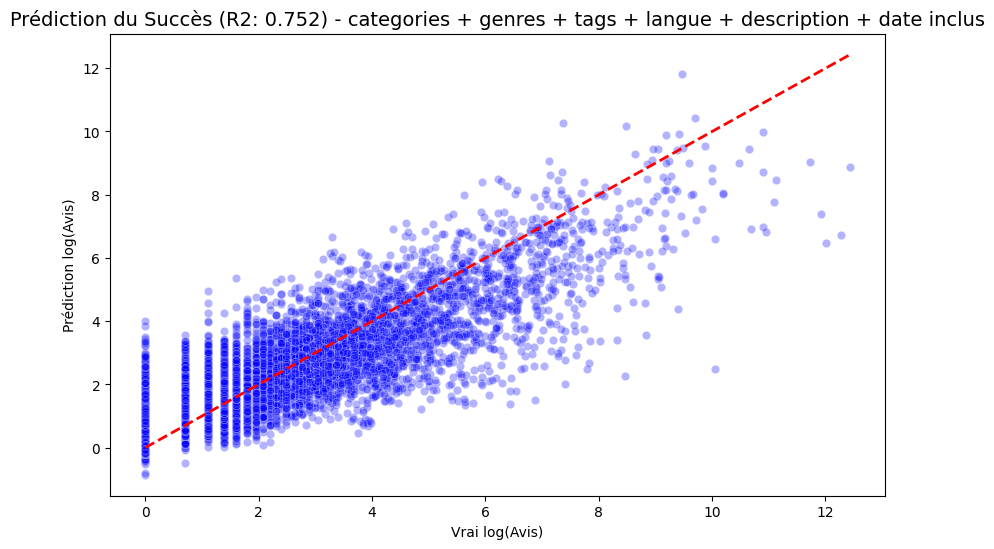

Exemples de prédictions :
                             Titre  Vrai_Avis  Prediction
1246   Monster: Titan's Playground      143.0    8.792652
44720   Pro Strategy Football 2026       13.0   22.083060
12829             Unsolved Stories       10.0  204.829601
2331             Really Trash Game       11.0    3.949806
12428                Diamond Deeps        4.0    2.240679
32513  Battle Line the Rise of War        1.0    1.224261
33466         Cyber Badminton 2020        6.0    4.304014
13561         Raiders of Blackveil        0.0   -0.016586
45825                      Eveslan        0.0    1.327673
7708   Gravity SQUARE -グラビティ スクエア-        1.0    0.281510
            Feature Id  Importances
0           categories    23.638281
1                 prix    21.368731
2    tags_utilisateurs    21.194768
3                annee    14.457837
4        nombre_succes     6.252180
5               genres     4.005558
6      langues_partiel     3.811413
7    N_langues_partiel     2.463477
8           

In [11]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet"]#,"description_detaillee"]
cols_cat = ["mois","annee","cluster_BERTopic_K"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)

for col in ["mois", "annee"]:
    X[col] = X[col].fillna(0).astype(int).astype(str)

Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    depth=8,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    task_type="CPU",
    early_stopping_rounds=30
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"RMSE log space : {np.sqrt(mean_squared_error(np.log1p(y_test), y_pred_log))}")
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + langue + description + date inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

In [34]:
df["plateformes"]

0                    [windows]
1               [windows, mac]
2                    [windows]
3        [windows, mac, linux]
4                    [windows]
                 ...          
46038                [windows]
46039                [windows]
46040                [windows]
46041         [windows, linux]
46042                [windows]
Name: plateformes, Length: 46043, dtype: object

In [40]:
platforms = ["mac", "windows", "linux"]

for p in platforms:
    df[p] = df["plateformes"].apply(lambda x: int(p in x))

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'langues_partiel', 'langues_complet']...
Learning rate set to 0.089701
0:	learn: 1.9908838	test: 4770.8164579	best: 4770.8164579 (0)	total: 1.73s	remaining: 28m 44s
100:	learn: 1.0358169	test: 4770.5390993	best: 4770.5390993 (100)	total: 1m 47s	remaining: 15m 52s
200:	learn: 0.9418903	test: 4770.5208610	best: 4770.5208610 (200)	total: 3m 48s	remaining: 15m 8s
300:	learn: 0.8854524	test: 4770.5149821	best: 4770.5149821 (300)	total: 5m 45s	remaining: 13m 21s
400:	learn: 0.8424471	test: 4770.5099105	best: 4770.5098830 (399)	total: 7m 45s	remaining: 11m 35s
500:	learn: 0.8044347	test: 4770.5085092	best: 4770.5080928 (485)	total: 9m 36s	remaining: 9m 34s
600:	learn: 0.7726736	test: 4770.5072451	best: 4770.5064988 (586)	total: 11m 22s	remaining: 7m 32s
700:	learn: 0.7434830	test: 4770.5069160	best: 4770.5064988 (586)	total: 13m 14s	remaining: 5m 38s
800:	learn: 0.7171120	test: 4770.5072467	best: 4770.5064988 (586)	tota

/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_60970/3526840341.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


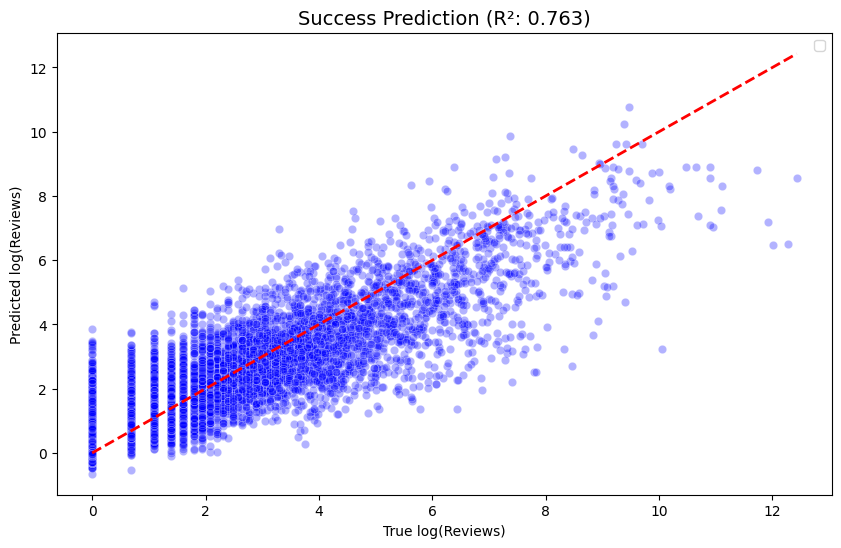

Exemples de prédictions :
                               Titre  Vrai_Avis    Prediction
17398                Mishaka Ubivaka        0.0      2.165393
18848  化者天狱 Revenant in the Paradise        0.0      0.551474
42111                 Operation Octo       40.0     14.264458
33658           Rionag: Survey Fleet        1.0     15.984100
19606                          Ashen     1588.0  19122.991959
16089       Craig 12: Craig's Escape        1.0      1.309334
39815                     Neon Blood       27.0     28.066263
42954               My Ex is a Ghost        0.0     -0.029058
2517                 Your Spaceport!        6.0      1.887927
35980                Radiant Melodia        1.0      5.215942
            Feature Id  Importances
0    tags_utilisateurs    24.021985
1           categories    21.360728
2                 prix    16.038852
3                annee    15.018393
4        nombre_succes     6.743769
5               genres     4.759600
6      langues_partiel     4.498967
7   

In [52]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet"]#,"description_detaillee"]
cols_cat = ["mois","annee","mac",'linux',"windows","cluster_BERTopic_K"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols+ cols_cat + cols_text
target = "review"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col)

for col in ["mois", "annee"]:
    X[col] = X[col].fillna(0).astype(int).astype(str)

Y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_test = np.expm1(y_test)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    task_type="CPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(np.log1p(y_test), y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"RMSE log space : {np.sqrt(mean_squared_error(np.log1p(y_test), y_pred_log))}")
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(y_test), y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, np.log1p(y_test).max()], [0, np.log1p(y_test).max()], 'r--', lw=2)
plt.title(f"Success Prediction (R²: {score_r2:.3f})", fontsize=14)
plt.xlabel("True log(Reviews)")
plt.ylabel("Predicted log(Reviews)")
plt.legend()
plt.show()

results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': y_test,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)